In [7]:
import pandas as pd
import ssl

In [8]:
ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv("https://math.ucla.edu/~dmenezes/Antidiabetic.csv", index_col=0)

In [11]:
df.index = pd.to_datetime(df.index)

Text(0.5, 1.0, 'Diametic Drug Prescriptions in Australia')

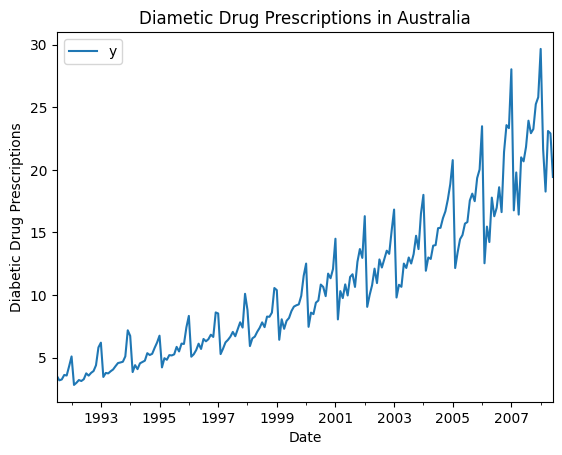

In [14]:
import matplotlib.pyplot as plt
df.plot()
plt.xlabel("Date")
plt.ylabel("Diabetic Drug Prescriptions")
plt.title("Diametic Drug Prescriptions in Australia")

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df, model='additive', period=12)

In [18]:
decomposition

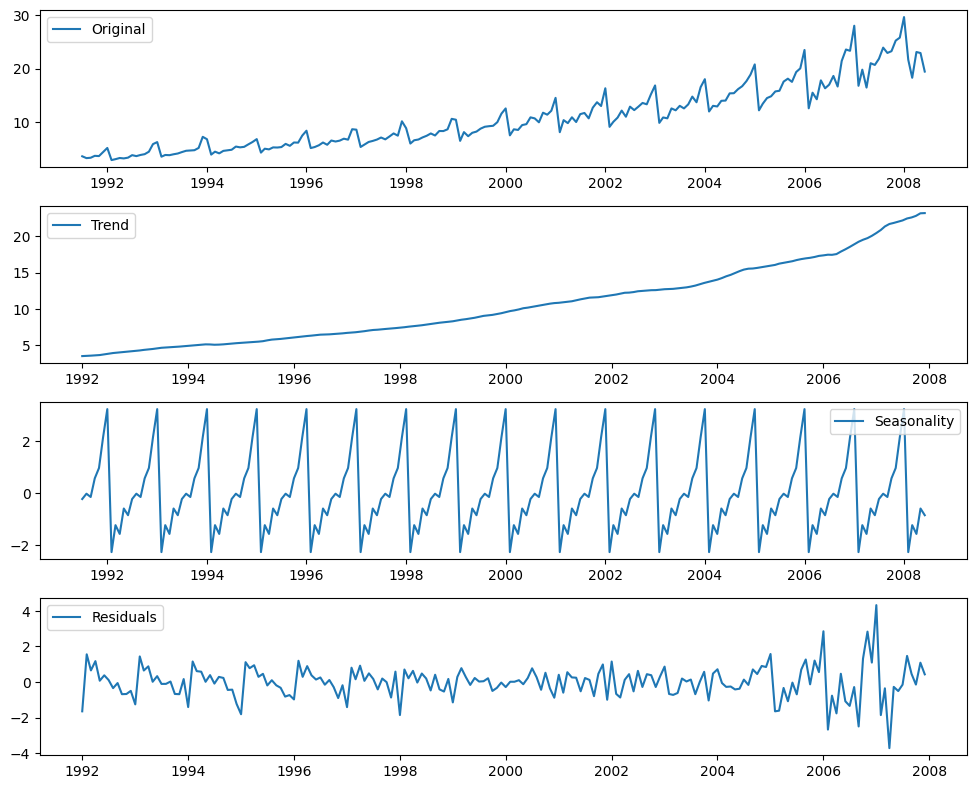

In [21]:
import matplotlib.pyplot as plt
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(df, label='Original')
plt.legend(loc='best')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [22]:
train = df[:-36]

In [53]:
test=df[-36:]

In [28]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.9 MB/s eta 0:00:00


In [58]:
from pmdarima.arima import auto_arima
model = auto_arima(train, seasonal=True, m=12,
                   start_p=0, d=2, start_q=0,
                   max_p=3, max_d=2, max_q=3,
                   start_P=0, D=0, start_Q=0,
                   max_P=3, max_D=3, max_Q=3,
                   trace=True, error_action='ignore', suppress_warnings=True)


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1028.016, Time=0.05 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=inf, Time=0.52 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=1.89 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=887.938, Time=0.52 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=774.041, Time=0.54 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=773.674, Time=1.27 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(0,2,0)(3,0,1)[12]             : AIC=766.037, Time=3.20 sec
 ARIMA(0,2,0)(3,0,0)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(0,2,0)(3,0,2)[12]             : AIC=inf, Time=6.04 sec
 ARIMA(0,2,0)(2,0,2)[12]             : AIC=768.587, Time=2.20 sec
 ARIMA(1,2,0)(3,0,1)[12]             : AIC=629.257, Time=3.95 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=637.071, Time=1.13 sec
 ARIMA(1,2,0)(3,0,0)[12]             : AIC=inf, Time=0.9

In [59]:
resid = model.resid()

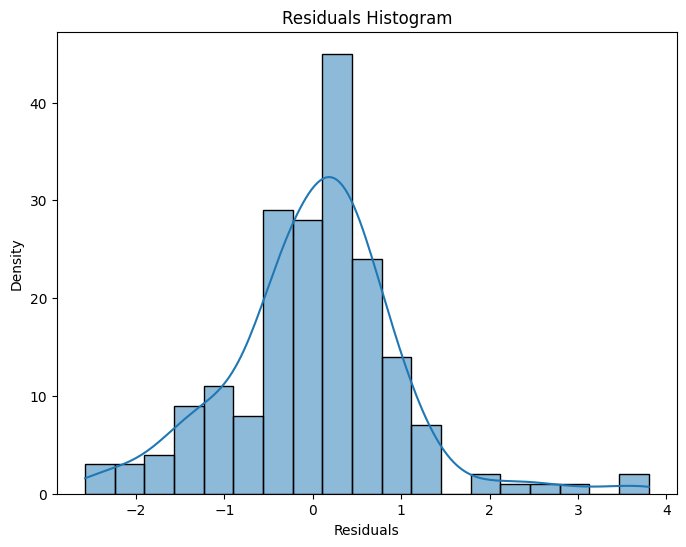

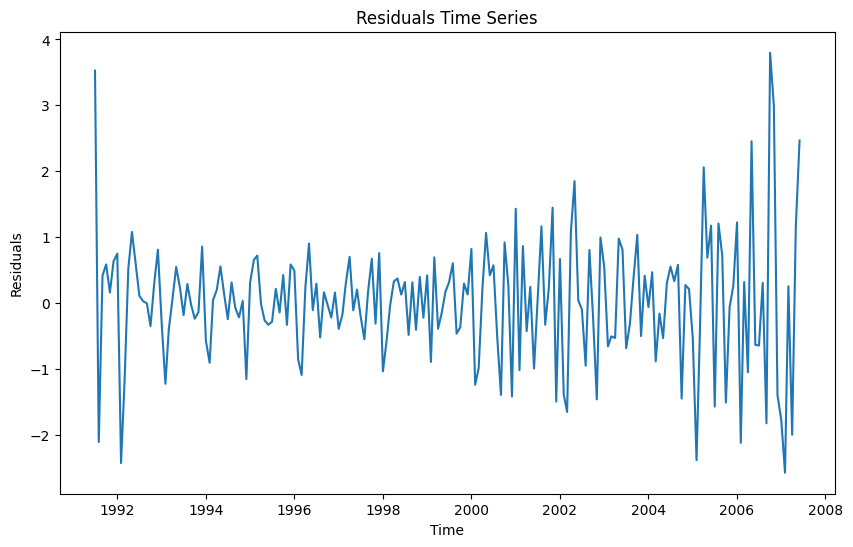

<Figure size 800x600 with 0 Axes>

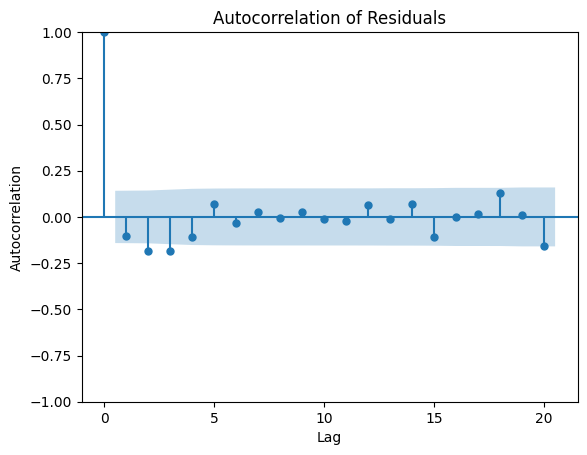

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(resid, kde=True)
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Plotting time series of residuals
plt.figure(figsize=(10, 6))
plt.plot(resid)
plt.title('Residuals Time Series')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Plotting autocorrelation of residuals
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(8, 6))
plot_acf(resid, lags=20)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [55]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(df)
print(ADF_result)

(3.145185689306745, 1.0, 15, 188, {'1%': -3.465620397124192, '5%': -2.8770397560752436, '10%': -2.5750324547306476}, 549.6705685364172)


In [56]:
ADF_result = adfuller(df.diff().dropna())
print(ADF_result)

(-2.4951721474497903, 0.1166534168646754, 15, 187, {'1%': -3.465811691080702, '5%': -2.877123351472649, '10%': -2.5750770662586864}, 547.1880809726358)


In [57]:
ADF_result = adfuller(df.diff().diff().dropna())
print(ADF_result)

(-10.292304706517392, 3.5439163585278875e-18, 14, 187, {'1%': -3.465811691080702, '5%': -2.877123351472649, '10%': -2.5750770662586864}, 548.8960194373418)


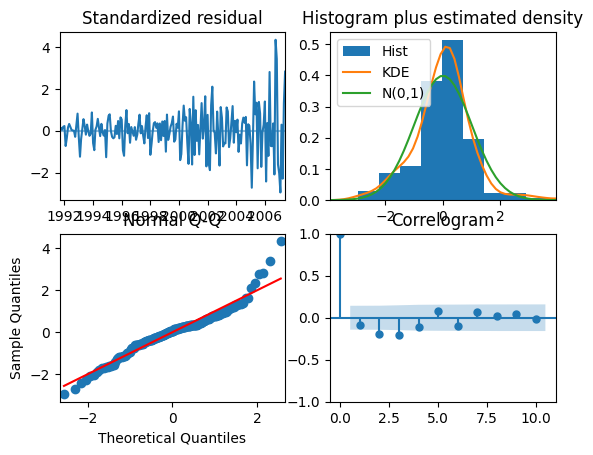

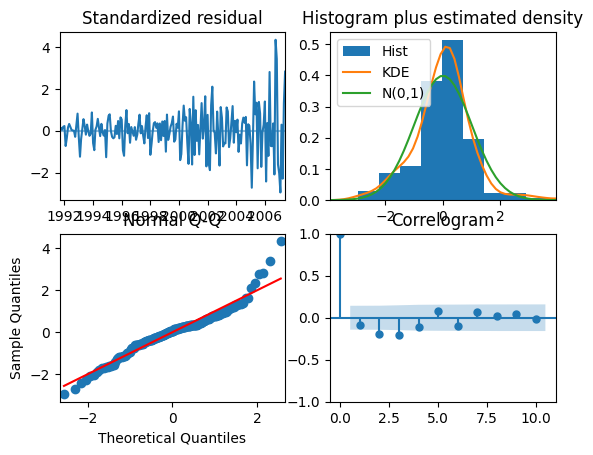

In [61]:
model.plot_diagnostics()

In [62]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create an empty array to store the forecasted values
rolling_forecast = np.empty(len(test))

# Iterate through the test set
for i in range(len(test)):
    # Concatenate the training predictions and observed values up to the current point
    history = np.concatenate([train.values, test.values[:i]])

    # Fit the ARIMA model on the concatenated data
    rolling_model = SARIMAX(history, order=(3,2,0), seasonal_order=(2,0,3,12))
    rolling_model_fit = rolling_model.fit()

    # Perform one-step ahead forecast for the next time point
    forecast = rolling_model_fit.forecast(steps=1)

    # Store the forecasted value in the rolling forecast array
    rolling_forecast[i] = forecast

# Convert the rolling forecast array into a pandas Series with proper index
rolling_forecast = pd.Series(rolling_forecast, index=test.index)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: Convergenc

In [64]:
# Calculate appropriate evaluation metrics based on your problem (e.g., Mean Squared Error, Mean Absolute Error)
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test, rolling_forecast)
mae = mean_absolute_error(test, rolling_forecast)

print("Rolling Forecast Evaluation:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Rolling Forecast Evaluation:
Mean Squared Error (MSE): 5.379786394524632
Mean Absolute Error (MAE): 1.8002139131984929


In [83]:
# Compute baseline forecasts
mean_forecast = np.mean(train)  # Mean forecast
naive_forecast = train.iloc[-1]      # Naive forecast (last observed value)
last_year_mean_forecast = np.mean(train.iloc[-12:])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [79]:
train.iloc[-1]

y    20.681002
Name: 2007-06-01 00:00:00, dtype: float64

In [85]:
# Evaluate performance metrics for baseline models
mse_mean = mean_squared_error(test, np.full_like(test, mean_forecast))
mae_mean = mean_absolute_error(test, np.full_like(test, mean_forecast))

mse_naive = mean_squared_error(test, np.full_like(test, naive_forecast))
mae_naive = mean_absolute_error(test, np.full_like(test, naive_forecast))


mse_lastyear = mean_squared_error(test, np.full_like(test, last_year_mean_forecast))
mae_lastyear = mean_absolute_error(test, np.full_like(test, last_year_mean_forecast))

In [86]:
print(f"Mean Model - Mean Squared Error (MSE): {mse_mean}")
print(f"Mean Model - Mean Absolute Error (MAE): {mae_mean}")
print(f"Naive Model - Mean Squared Error (MSE): {mse_naive}")
print(f"Naive Model - Mean Absolute Error (MAE): {mae_naive}")
print(f"Naive Model - Mean Squared Error (MSE): {mse_lastyear}")
print(f"Naive Model - Mean Absolute Error (MAE): {mae_lastyear}")

Mean Model - Mean Squared Error (MSE): 121.70674349127226
Mean Model - Mean Absolute Error (MAE): 10.348422333871529
Naive Model - Mean Squared Error (MSE): 14.791566460460501
Naive Model - Mean Absolute Error (MAE): 3.213737711388889
Naive Model - Mean Squared Error (MSE): 14.616972367282582
Naive Model - Mean Absolute Error (MAE): 3.1909960863888895


ValueError: ignored

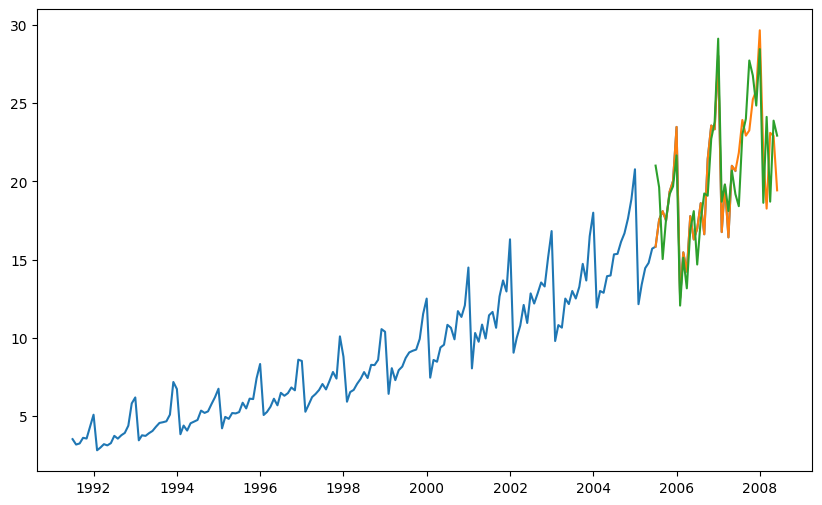

In [88]:
import matplotlib.pyplot as plt

# Plotting the original data, SARIMAX forecast, and baseline forecasts
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(rolling_forecast, label='SARIMAX Forecast')
plt.axhline(mean_forecast, color='red', linestyle='--', label='Mean Forecast')
plt.axhline(naive_forecast, color='green', linestyle='--', label='Naive Forecast')
plt.legend(loc='best')
plt.title('Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()